<a href="https://colab.research.google.com/github/jcmachicao/deeplearning_gestionpublica/blob/main/gdmk_nn_2022_clas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalaciones necesarias para GPU Rental
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

### Librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Verificación de GPU

In [ ]:
# Verificación de GPU
torch.cuda.device_count(), torch.cuda.get_device_name(0)

### Carga de Datos

In [ ]:
# Acondicionar la ruta dependiendo del entorno en el que se trabaja
#ruta = 'D:\2021_mod\mod_lineatiempo_papa\model_carga\'
#ruta = 'D://2021_mod/austin_crime_analysis/'
ruta = ''
#tipo_modelo = 'REGRESION'
tipo_modelo = 'CLASIFICACION'

In [ ]:
X_np = np.load(ruta + 'X_in_crime.npy')
y_np = np.load(ruta + 'y_in_crime.npy')
print(X_np.shape, y_np.shape)

(26011, 15) (26011, 1)


In [ ]:
X = torch.from_numpy(X_np.astype('float64'))
y = torch.squeeze(torch.from_numpy(np.array(y_np)))
print(X.shape, y.shape)

torch.Size([26011, 15]) torch.Size([26011])


### Arquitectura de Red

In [ ]:
# Arquitectura
class NetReg(nn.Module):

  def __init__(self):
    super(NetReg, self).__init__()
    self.fc1 = nn.Linear(15, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 1)
    self.dp1 = nn.Dropout(0.15)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
# Arquitectura
class NetClas(nn.Module):

  def __init__(self):
    super(NetClas, self).__init__()
    self.fc1 = nn.Linear(15, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 5)
    self.dp1 = nn.Dropout(0.15)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return F.log_softmax(x, dim=1)

In [ ]:
if tipo_modelo == 'REGRESION':
  model = NetReg()
else:
  model = NetClas()

### Rescate de modelo entrenado

In [ ]:
#ruta_r = 'D://2021_mod/austin_crime_analysis/Res2/'
ruta_r = ''
nom_model = ruta_r + 'modelo_austin_clas_v2.pth'
modelo_load = nom_model
model.load_state_dict(torch.load(modelo_load, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model

NetClas(
  (fc1): Linear(in_features=15, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
  (dp1): Dropout(p=0.15, inplace=False)
)

### Montaje de Elementos en CUDA

In [ ]:
model.cuda(0)
#X_g = X_cv.cuda(0)
X_g = X.cuda(0)
y_g = y.cuda(0)
X_g.shape, y_g.shape

(torch.Size([26011, 15]), torch.Size([26011]))

### Testing

In [ ]:
pred_df = pd.DataFrame()
out = model(X_g.float())
print(out)
y_hat = torch.argmax(out, 1).cpu().detach()
pred_df['y_orig'] = y.long()
pred_df['y_hat'] = y_hat
pred_df.to_excel(ruta_r + 'pred_austin_clas_v1.xlsx')

tensor([[-3.4445e-03, -9.3583e+01, -5.6727e+00, -1.9080e+02, -2.6224e+01],
        [-2.4337e+01, -5.3973e-01, -8.9650e-01, -4.6995e+00, -2.9751e+01],
        [-1.9840e+01, -3.7341e+00, -1.5613e-01, -2.1148e+00, -3.0162e+01],
        ...,
        [-1.4680e+00, -5.6062e+00, -5.7630e+00, -6.4073e+00, -2.7292e-01],
        [-3.4323e+01, -7.8679e-01, -6.8268e-01, -3.2332e+00, -3.4046e+01],
        [-1.3780e+01, -2.4448e+00, -7.4017e-01, -8.3059e-01, -7.7612e+00]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


### Continua Entrenamiento

In [ ]:
nit = -1
learning_rate = 0.001
errores = []
precision = []

In [ ]:
# Para clasificación
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.CrossEntropyLoss() # Para clasificación

# Para regresión
#criterion = nn.MSELoss()  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
num_epochs = 100000

In [ ]:
for c in range(2):
    
  print('Ciclo: ', c)
  nit += 1
  start = time.time()

  for epoch in range(num_epochs):
        
    optimizer.zero_grad()
    scores = model(X_g.float())
    loss = F.nll_loss(scores, y_g.long())
    #loss = criterion(scores, y)
    loss.backward()
    optimizer.step()
    
    if epoch % int(num_epochs/10) == 0:
        
        end = time.time()
        errores.append([epoch+nit*num_epochs, loss.item()])
        
        pred = scores.cpu().detach().numpy()
        predicts = pd.DataFrame(np.argmax(pred, 1))
        predicts.columns = ['preds']
        predicts['y_orig'] = y
        predicts['acierto'] = (predicts.preds == predicts.y_orig)*1
        precis = predicts.acierto.sum()/len(predicts)
        precision.append(precis)
        
        print(epoch+nit*num_epochs, '{0: .5f}'.format(loss.item()), '{0: .2f}'.format(end-start),  '{0: .4f}'.format(precis))
        start = end
        
print('Ciclo Finalizado')

In [ ]:
nombre = 'austin_clas_'
version = 'v4'

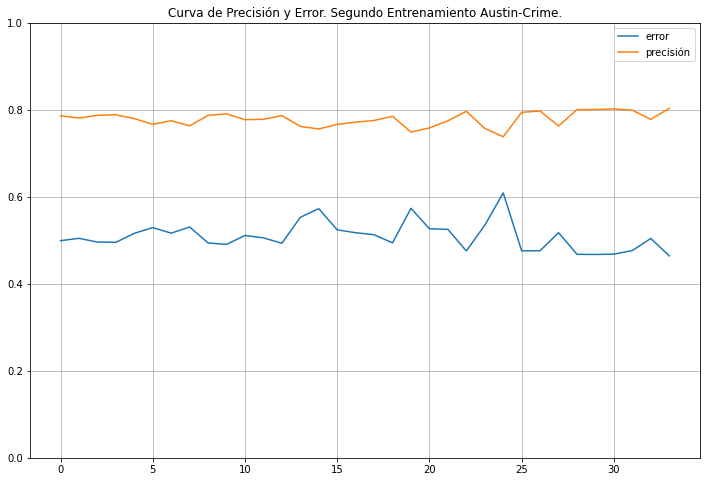

In [ ]:
err_df = pd.DataFrame(errores)
prec_df = pd.DataFrame(precision)

plt.figure(figsize=(12,8))
plt.plot(err_df[1], label='error')
plt.plot(prec_df[0], label='precisión')
plt.grid(True)
plt.ylim(0,1)
plt.title('Curva de Precisión y Error. Segundo Entrenamiento Austin-Crime.')
plt.legend(loc='best')
plt.savefig('error_precision.png')
plt.show()

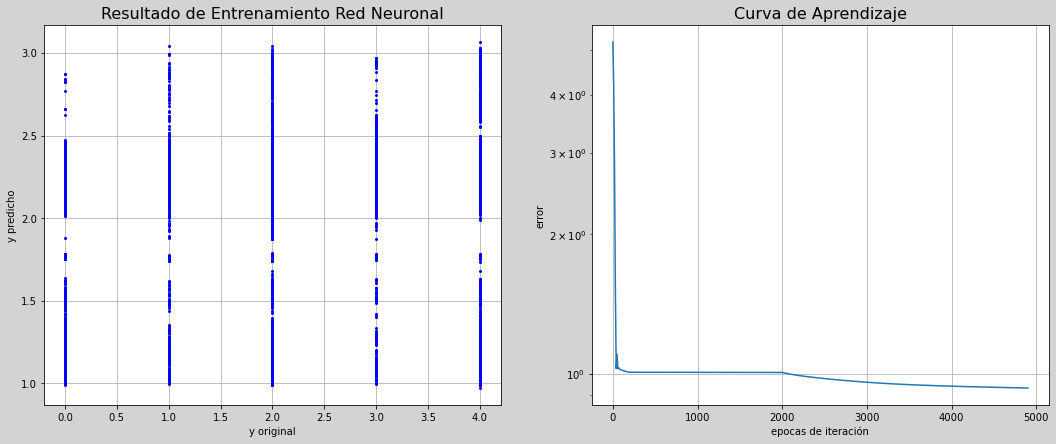

In [ ]:
#@title Gráficas de Regresión
f = plt.figure(figsize=(18,7), facecolor='lightgray')

ax1 = f.add_subplot(121)
ax1.plot(y_np, pred, 'bo', ms=2, label='Red Neuronal')
#ax1.plot([0,1], [0, 1], 'b:', lw=2)
ax1.set_title('Resultado de Entrenamiento Red Neuronal', fontsize=16)
ax1.set_xlabel('y original')
ax1.set_ylabel('y predicho')
plt.grid(True)

ax2 = f.add_subplot(122)
ax2.plot(err_df[0], err_df[1])
ax2.set_title('Curva de Aprendizaje', fontsize=16)
ax2.set_xlabel('epocas de iteración')
ax2.set_ylabel('error')
ax2.set_yscale('log')

plt.savefig('Resultados/curvas_precision_aprendizaje.png')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = 'drive/My Drive/00 Modelos Principales/modelos/'
torch.save(model.state_dict(), ruta + 'modelo_'+nombre+version+'.pth')
pred_df = pd.DataFrame(pred)
pred_df.to_csv(ruta + 'preds_'+nombre+version+'.csv')
errores_df = pd.DataFrame(errores)
errores_df.to_csv(ruta + 'errors_'+nombre+version+'.csv')


In [ ]:
pred = scores.cpu().detach().numpy()
predicts = pd.DataFrame(np.argmax(pred, 1))
predicts.columns = ['preds']
predicts['y_orig'] = y
predicts['acierto'] = (predicts.preds == predicts.y_orig)*1
predicts.to_excel(ruta + 'predicciones.xlsx')